In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
import time
import sklearn
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
from tabulate import tabulate
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [21]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [22]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
            
    return files_add

files_add=find_the_way("./CV",".csv")
files_add

['./CV\\DoS-SYN.csv',
 './CV\\MB-ACK.csv',
 './CV\\MB-BF.csv',
 './CV\\MB-HDis.csv',
 './CV\\MB-HTTP.csv',
 './CV\\MB-UDP.csv',
 './CV\\MitM-ARP.csv',
 './CV\\Scan-HDis.csv',
 './CV\\Scan-OS.csv',
 './CV\\Scan-Port.csv',
 './CV\\SPScan-Port.csv']

In [23]:
ml_list={"DT": DecisionTreeClassifier()}#,"SVC":SVC()}}

In [24]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [25]:
folder("results/compare/SS/")
folder("results/compare/CV/")
folder("results/compare/DD/")
folder("pdfs")

## Calculation of evaluations

In [26]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [27]:
def ML(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=25
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

                df = pd.read_csv(loop1,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_train =df[df.columns[0:-1]]
                X_train=np.array(X_train)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_train=df[df.columns[-1]].cat.codes  


                df = pd.read_csv(loop2,usecols=cols)#,header=None )
                df=df.fillna(0)
                X_test =df[df.columns[0:-1]]
                X_test=np.array(X_test)
                df[df.columns[-1]] = df[df.columns[-1]].astype('category')
                y_test=df[df.columns[-1]].cat.codes  


                #dname=loop1  [6:-13]  
                results_y=[]
       
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
       
        results=results.mean()
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)






In [28]:
def ML_CV(loop1,loop2,output_csv,cols,dname,sw):
    fold=5
    repetition=5
    for ii in ml_list:
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Attack","Feature","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  

                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )
    
                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)

        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)

        results=results.mean()
        results=results.round(3)
        #print (tabulate(results, headers=list(results.columns)))
        #print()
        return list(results.values)





In [29]:
features=[ 'IP_id','ICMP_chksum', 'ICMP_id','TCP_seq', 'TCP_ack','TCP_chksum', 'UDP_chksum','DNS_id','BOOTP_xid', 'sport','dport','sport_class', 'dport_class']
    #['random', 'TCP_FIN_R', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_URG_R', 'TCP_ECE_R', 'TCP_CWR_R']

In [30]:
len(features)

13

In [31]:
file_list={'./CV\\DoS-SYN.csv':"SYN",
 './CV\\MB-ACK.csv':"ACK",
 './CV\\MB-BF.csv':"BF",
 './CV\\MB-HDis.csv':"MHDis",
 './CV\\MB-HTTP.csv':"HTTP",
 './CV\\MB-UDP.csv':"UDP",
 './CV\\MitM-ARP.csv':"ARP",
 './CV\\Scan-HDis.csv':"SCHD",
 './CV\\Scan-OS.csv':"OS",  
 './CV\\Scan-Port.csv':"SP"}

# CV

In [32]:
for train in (file_list):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):
        try:
            target_names=["attack","benign"]
            feature=[dname, 'Label']
            output_csv=f"./results/compare/CV/ET_{file_list[train]}_{dname}.csv"
            #print(f"{list[train]} Dataset - Feature {number+1}/{len(features)}")
            temp=ML_CV(train,"",output_csv,feature,dname,file_list[train])
            temp=temp[2:]
            temp=[file_list[train],dname,"ET"]+temp
            lines.append(temp)
            
        except:
            print("#"*110)
            print(f"ERROR ABOUT {list[train]} Dataset - Feature {dname}")
            print("#"*110+"\n\n")

    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.10s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN       IP_id        ET    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.009     0.002
 1  SYN       ICMP_chksum  ET    0.558    0.5     0.279  0.5    0.358  0      0.5      0.005     0
 2  SYN       ICMP_id      ET    0.558    0.5     0.279  0.5    0.358  0      0.5      0.004     0.001
 3  SYN       TCP_seq      ET    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.049     0
 4  SYN       TCP_ack      ET    0.94     0.946   0.94   0.946  0.94   0.88   0.946    0.017     0
 5  SYN       TCP_chksum   ET    0.557    0.546   0.547  0.546  0.546  0.093  0.546    0.415     0.006
 6  SYN       UDP_chksum   ET    0.558    0.5     0.279  0.5    0.358  0      0.5      0.004     0
 7  SYN       DNS_id       ET    0.558    0.5     0.279  0.5    0.358  0      0.5      0.

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:53<00:00,  4.15s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK       IP_id        ET    1        1       1      1      1      1      1        0.006     0.001
 1  ACK       ICMP_chksum  ET    0.617    0.5     0.308  0.5    0.381  0      0.5      0.003     0.001
 2  ACK       ICMP_id      ET    0.617    0.5     0.308  0.5    0.381  0      0.5      0.002     0
 3  ACK       TCP_seq      ET    1        1       1      1      1      1      1        0.018     0.001
 4  ACK       TCP_ack      ET    0.737    0.787   0.796  0.787  0.737  0.508  0.787    0.016     0
 5  ACK       TCP_chksum   ET    0.805    0.789   0.794  0.789  0.791  0.583  0.789    0.126     0.003
 6  ACK       UDP_chksum   ET    0.64     0.708   0.758  0.708  0.634  0.353  0.708    0.005     0
 7  ACK       DNS_id       ET    0.617    0.5     0.308  0.5    0.381  0      0.5    

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:33<00:00,  2.58s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF        IP_id        ET    0.99     0.815   0.878  0.815  0.842  0.684  0.815    0.007     0.001
 1  BF        ICMP_chksum  ET    0.983    0.5     0.491  0.5    0.496  0      0.5      0.003     0
 2  BF        ICMP_id      ET    0.983    0.5     0.491  0.5    0.496  0      0.5      0.003     0
 3  BF        TCP_seq      ET    0.999    0.999   0.97   0.999  0.984  0.968  0.999    0.023     0.001
 4  BF        TCP_ack      ET    0.997    0.94    0.971  0.94   0.955  0.91   0.94     0.026     0.001
 5  BF        TCP_chksum   ET    0.97     0.532   0.536  0.532  0.533  0.067  0.532    0.067     0.001
 6  BF        UDP_chksum   ET    0.983    0.5     0.491  0.5    0.496  0      0.5      0.004     0
 7  BF        DNS_id       ET    0.983    0.5     0.491  0.5    0.496  0      0.5    

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.35s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis     IP_id        ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.008     0
 1  MHDis     ICMP_chksum  ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.002     0.001
 2  MHDis     ICMP_id      ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.002     0
 3  MHDis     TCP_seq      ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.003     0.001
 4  MHDis     TCP_ack      ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.007     0
 5  MHDis     TCP_chksum   ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.005     0.001
 6  MHDis     UDP_chksum   ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.001     0
 7  MHDis     DNS_id       ET    0.989    0.5     0.495  0.5    0.497  0      0.5      0.

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:50<00:00,  3.85s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP      IP_id        ET    0.933    0.566   0.586  0.566  0.574  0.149  0.566    0.048     0.001
 1  HTTP      ICMP_chksum  ET    0.954    0.5     0.477  0.5    0.488  0      0.5      0.002     0.002
 2  HTTP      ICMP_id      ET    0.954    0.5     0.477  0.5    0.488  0      0.5      0.004     0.001
 3  HTTP      TCP_seq      ET    0.987    0.907   0.944  0.907  0.924  0.849  0.907    0.031     0.001
 4  HTTP      TCP_ack      ET    0.977    0.794   0.928  0.794  0.847  0.694  0.794    0.023     0
 5  HTTP      TCP_chksum   ET    0.922    0.518   0.522  0.518  0.519  0.039  0.518    0.133     0.003
 6  HTTP      UDP_chksum   ET    0.954    0.5     0.477  0.5    0.488  0      0.5      0.004     0
 7  HTTP      DNS_id       ET    0.954    0.5     0.477  0.5    0.488  0      0.5

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:52<00:00,  4.07s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP       IP_id        ET    0.705    0.674   0.665  0.674  0.669  0.338  0.674    0.141     0.001
 1  UDP       ICMP_chksum  ET    0.683    0.5     0.801  0.5    0.407  0.001  0.5      0.001     0.002
 2  UDP       ICMP_id      ET    0.683    0.5     0.781  0.5    0.406  0.001  0.5      0.003     0
 3  UDP       TCP_seq      ET    0.837    0.744   0.904  0.744  0.774  0.565  0.744    0.004     0.001
 4  UDP       TCP_ack      ET    0.836    0.741   0.903  0.741  0.772  0.56   0.741    0.003     0
 5  UDP       TCP_chksum   ET    0.837    0.744   0.904  0.744  0.774  0.565  0.744    0.006     0.001
 6  UDP       UDP_chksum   ET    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.034     0.001
 7  UDP       DNS_id       ET    0.683    0.501   0.842  0.501  0.407  0.002  0.5

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:02<00:00,  4.80s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP       IP_id        ET    0.785    0.792   0.797  0.792  0.785  0.575  0.792    0.061     0.001
 1  ARP       ICMP_chksum  ET    0.72     0.74    0.812  0.74   0.708  0.46   0.74     0.002     0.001
 2  ARP       ICMP_id      ET    0.538    0.5     0.269  0.5    0.35   0      0.5      0.003     0.001
 3  ARP       TCP_seq      ET    0.894    0.901   0.904  0.901  0.894  0.791  0.901    0.031     0.001
 4  ARP       TCP_ack      ET    0.877    0.885   0.892  0.885  0.877  0.757  0.885    0.032     0.001
 5  ARP       TCP_chksum   ET    0.775    0.772   0.774  0.772  0.773  0.546  0.772    0.221     0.005
 6  ARP       UDP_chksum   ET    0.538    0.5     0.269  0.5    0.35   0      0.5      0.005     0.001
 7  ARP       DNS_id       ET    0.538    0.5     0.269  0.5    0.35   0 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.38s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD      IP_id        ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.009     0.001
 1  SCHD      ICMP_chksum  ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.001     0.001
 2  SCHD      ICMP_id      ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.002     0
 3  SCHD      TCP_seq      ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.006     0.001
 4  SCHD      TCP_ack      ET    0.989    0.994   0.888  0.994  0.934  0.868  0.994    0.002     0
 5  SCHD      TCP_chksum   ET    0.99     0.995   0.895  0.995  0.938  0.877  0.995    0.005     0
 6  SCHD      UDP_chksum   ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.001     0
 7  SCHD      DNS_id       ET    0.963    0.5     0.482  0.5    0.491  0      0.5      0.

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.77s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS        IP_id        ET    0.946    0.503   0.575  0.503  0.493  0.01   0.503    0.02      0.001
 1  OS        ICMP_chksum  ET    0.947    0.5     0.474  0.5    0.486  0      0.5      0.004     0
 2  OS        ICMP_id      ET    0.947    0.5     0.474  0.5    0.486  0      0.5      0.002     0.001
 3  OS        TCP_seq      ET    0.995    0.991   0.962  0.991  0.976  0.952  0.991    0.026     0
 4  OS        TCP_ack      ET    0.98     0.889   0.92   0.889  0.898  0.796  0.889    0.017     0.001
 5  OS        TCP_chksum   ET    0.93     0.641   0.645  0.641  0.642  0.285  0.641    0.086     0.002
 6  OS        UDP_chksum   ET    0.947    0.501   0.644  0.501  0.488  0.003  0.501    0.003     0.001
 7  OS        DNS_id       ET    0.947    0.5     0.474  0.5    0.486  0      0.5

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:08<00:00,  5.27s/it]

    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP        IP_id        ET    0.909    0.784   0.789  0.784  0.787  0.573  0.784    0.113     0.002
 1  SP        ICMP_chksum  ET    0.877    0.5     0.439  0.5    0.467  0      0.5      0.004     0.002
 2  SP        ICMP_id      ET    0.877    0.5     0.439  0.5    0.467  0      0.5      0.003     0
 3  SP        TCP_seq      ET    1        1       0.999  1      1      0.999  1        0.029     0
 4  SP        TCP_ack      ET    0.989    0.993   0.959  0.993  0.975  0.95   0.993    0.012     0.002
 5  SP        TCP_chksum   ET    0.889    0.717   0.742  0.717  0.728  0.457  0.717    0.119     0.004
 6  SP        UDP_chksum   ET    0.877    0.5     0.439  0.5    0.467  0      0.5      0.002     0.001
 7  SP        DNS_id       ET    0.877    0.5     0.439  0.5    0.467  0      0.5

# Session vs Session

In [33]:
file_list={"SYN":['./SM/DoS-SYN-1.csv','./SM/DoS-SYN-2.csv'],
"HTTP":['./SM/MB-HTTP-1.csv','./SM/MB-HTTP-2.csv'],
"ACK":['./SM/MB-ACK-1.csv','./SM/MB-ACK-2.csv'],
"UDP":['./SM/MB-UDP-1.csv','./SM/MB-UDP-2.csv'],
"ARP":['./SM/MitM-ARP-1.csv','./SM/MitM-ARP-2.csv'],
"SP":['./SM/Scan-Port-1.csv','./SM/Scan-Port-2.csv'],
"BF":['./SM/MB-BF-1.csv','./SM/MB-BF-2.csv'],
"OS":['./SM/Scan-OS-1.csv','./SM/Scan-OS-2.csv'],
"SCHD":['./SM/Scan-HDis-1.csv','./SM/Scan-HDis-2.csv'],
"MHDis":['./SM/MB-HDis-1.csv','./SM/MB-HDis-2.csv']}

In [34]:
for train in (file_list):
    lines=[["Attack","Feature","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
    for dname in tqdm(features):
        try:
            target_names=["attack","benign"]
            feature=[dname, 'Label']
            
            output_csv=f"./results/compare/SS/ET_{train}_{dname}.csv"
            temp=ML(file_list[train][0],file_list[train][1],output_csv,feature,dname,train)  
            temp=temp[2:]
            temp=[train,dname,"ET"]+temp
            lines.append(temp)
        except:
            print("#"*110)
            print(f"ERROR ABOUT {list[train]} Dataset - Feature {dname}")
            print("#"*110+"\n\n")

    results = pd.DataFrame (lines[1:], columns = lines[0])
    print (tabulate(results, headers=list(results.columns)))




100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:57<00:00, 13.62s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN       IP_id        ET    0.971    0.974   0.968  0.974  0.97   0.941  0.974    0.005     0.002
 1  SYN       ICMP_chksum  ET    0.574    0.5     0.287  0.5    0.365  0      0.5      0.002     0.001
 2  SYN       ICMP_id      ET    0.574    0.5     0.287  0.5    0.365  0      0.5      0.003     0.001
 3  SYN       TCP_seq      ET    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.018     0.003
 4  SYN       TCP_ack      ET    0.874    0.891   0.886  0.891  0.874  0.753  0.891    0.011     0.001
 5  SYN       TCP_chksum   ET    0.555    0.539   0.54   0.539  0.538  0.078  0.539    0.252     0.012
 6  SYN       UDP_chksum   ET    0.574    0.5     0.287  0.5    0.365  0      0.5      0.003     0.001
 7  SYN       DNS_id       ET    0.574    0.5     0.287  0.5    0.365  0 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:26<00:00, 15.89s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  HTTP      IP_id        ET    0.842    0.474   0.491  0.474  0.475  -0.026  0.474    0.02      0.002
 1  HTTP      ICMP_chksum  ET    0.96     0.5     0.48   0.5    0.49    0      0.5      0.003     0.001
 2  HTTP      ICMP_id      ET    0.96     0.5     0.48   0.5    0.49    0      0.5      0.003     0.001
 3  HTTP      TCP_seq      ET    0.799    0.711   0.549  0.711  0.541   0.139  0.711    0.01      0.002
 4  HTTP      TCP_ack      ET    0.817    0.675   0.545  0.675  0.541   0.128  0.675    0.015     0.003
 5  HTTP      TCP_chksum   ET    0.936    0.518   0.524  0.518  0.52    0.041  0.518    0.075     0.007
 6  HTTP      UDP_chksum   ET    0.96     0.5     0.48   0.5    0.49    0      0.5      0.002     0.001
 7  HTTP      DNS_id       ET    0.96     0.5     0.48   0.5    

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:39<00:00, 16.92s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK       IP_id        ET    1        1       1      1      1       1      1        0.005     0
 1  ACK       ICMP_chksum  ET    0.072    0.5     0.536  0.5    0.068   0      0.5      0.002     0.001
 2  ACK       ICMP_id      ET    0.072    0.5     0.536  0.5    0.067   0      0.5      0.002     0.001
 3  ACK       TCP_seq      ET    0.995    0.998   0.97   0.998  0.983   0.967  0.998    0.013     0.001
 4  ACK       TCP_ack      ET    0.4      0.676   0.553  0.676  0.358   0.073  0.676    0.007     0.001
 5  ACK       TCP_chksum   ET    0.842    0.573   0.545  0.573  0.551   0.109  0.573    0.095     0.002
 6  ACK       UDP_chksum   ET    0.569    0.768   0.571  0.768  0.473   0.142  0.768    0.002     0.002
 7  ACK       DNS_id       ET    0.072    0.5     0.536  0.5    0.06

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:30<00:00, 16.18s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  UDP       IP_id        ET    0.643    0.7     0.745  0.7    0.636   0.348  0.7      0.075     0.003
 1  UDP       ICMP_chksum  ET    0.397    0.5     0.698  0.5    0.285   0.001  0.5      0.002     0.001
 2  UDP       ICMP_id      ET    0.397    0.5     0.698  0.5    0.285   0.001  0.5      0.003     0.001
 3  UDP       TCP_seq      ET    0.675    0.73    0.775  0.73   0.67    0.404  0.73     0.003     0.002
 4  UDP       TCP_ack      ET    0.671    0.727   0.773  0.727  0.666   0.398  0.727    0.003     0.001
 5  UDP       TCP_chksum   ET    0.676    0.732   0.775  0.732  0.672   0.406  0.732    0.003     0.001
 6  UDP       UDP_chksum   ET    0.568    0.471   0.294  0.471  0.362  -0.069  0.471    0.015     0.002
 7  UDP       DNS_id       ET    0.397    0.501   0.698  0.501  

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:53<00:00, 18.00s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP       IP_id        ET    0.574    0.558   0.558  0.558  0.558   0.116  0.558    0.039     0.001
 1  ARP       ICMP_chksum  ET    0.601    0.67    0.749  0.67   0.586   0.289  0.67     0.003     0.002
 2  ARP       ICMP_id      ET    0.398    0.501   0.698  0.501  0.286   0.002  0.501    0.002     0.001
 3  ARP       TCP_seq      ET    0.595    0.493   0.3    0.493  0.373  -0.017  0.493    0.018     0.001
 4  ARP       TCP_ack      ET    0.594    0.492   0.303  0.492  0.373  -0.019  0.492    0.015     0.002
 5  ARP       TCP_chksum   ET    0.623    0.644   0.641  0.644  0.622   0.267  0.644    0.078     0.006
 6  ARP       UDP_chksum   ET    0.417    0.517   0.702  0.517  0.321   0.027  0.517    0.002     0.001
 7  ARP       DNS_id       ET    0.399    0.502   0.699  0.502  

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:30<00:00, 11.59s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  SP        IP_id        ET    0.483    0.623   0.584  0.623  0.47    0.128  0.623    0.026     0.001
 1  SP        ICMP_chksum  ET    0.808    0.5     0.404  0.5    0.447   0      0.5      0.002     0
 2  SP        ICMP_id      ET    0.808    0.5     0.404  0.5    0.447   0      0.5      0.002     0.001
 3  SP        TCP_seq      ET    0.808    0.499   0.404  0.499  0.447  -0.002  0.499    0.003     0.001
 4  SP        TCP_ack      ET    0.992    0.995   0.979  0.995  0.987   0.974  0.995    0.003     0.001
 5  SP        TCP_chksum   ET    0.784    0.54    0.584  0.54   0.54    0.103  0.54     0.028     0.003
 6  SP        UDP_chksum   ET    0.808    0.5     0.404  0.5    0.447   0      0.5      0.001     0.001
 7  SP        DNS_id       ET    0.808    0.5     0.404  0.5    0.44

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:17<00:00, 10.58s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  BF        IP_id        ET    0.983    0.5     0.491  0.5    0.496   0      0.5      0.007     0.001
 1  BF        ICMP_chksum  ET    0.983    0.5     0.491  0.5    0.496   0      0.5      0.001     0.001
 2  BF        ICMP_id      ET    0.983    0.5     0.491  0.5    0.496   0      0.5      0.004     0.001
 3  BF        TCP_seq      ET    0.96     0.552   0.534  0.552  0.54    0.082  0.552    0.007     0.004
 4  BF        TCP_ack      ET    0.932    0.493   0.498  0.493  0.492  -0.007  0.493    0.007     0.001
 5  BF        TCP_chksum   ET    0.964    0.502   0.501  0.502  0.501   0.003  0.502    0.022     0.003
 6  BF        UDP_chksum   ET    0.983    0.5     0.491  0.5    0.496   0      0.5      0.003     0
 7  BF        DNS_id       ET    0.983    0.5     0.491  0.5    0.49

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:22<00:00, 11.00s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS        IP_id        ET    0.892    0.478   0.474  0.478  0.476  -0.047  0.478    0.011     0.001
 1  OS        ICMP_chksum  ET    0.94     0.5     0.47   0.5    0.484   0      0.5      0.002     0
 2  OS        ICMP_id      ET    0.94     0.5     0.47   0.5    0.484   0      0.5      0.001     0
 3  OS        TCP_seq      ET    0.475    0.428   0.484  0.428  0.356  -0.032  0.428    0.012     0.001
 4  OS        TCP_ack      ET    0.194    0.267   0.421  0.267  0.175  -0.07   0.267    0.01      0.001
 5  OS        TCP_chksum   ET    0.904    0.501   0.501  0.501  0.5     0.002  0.501    0.058     0.004
 6  OS        UDP_chksum   ET    0.94     0.5     0.47   0.5    0.484  -0      0.5      0.002     0
 7  OS        DNS_id       ET    0.94     0.5     0.47   0.5    0.484   0   

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:11<00:00, 10.15s/it]


    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD      IP_id        ET    0.968    0.5     0.484  0.5    0.492  0      0.5      0.004     0.002
 1  SCHD      ICMP_chksum  ET    0.968    0.5     0.484  0.5    0.492  0      0.5      0.002     0
 2  SCHD      ICMP_id      ET    0.968    0.5     0.484  0.5    0.492  0      0.5      0.002     0.001
 3  SCHD      TCP_seq      ET    0.968    0.5     0.484  0.5    0.492  0      0.5      0.003     0
 4  SCHD      TCP_ack      ET    0.99     0.995   0.883  0.995  0.931  0.863  0.995    0.003     0.001
 5  SCHD      TCP_chksum   ET    0.991    0.995   0.889  0.995  0.935  0.87   0.995    0.004     0.001
 6  SCHD      UDP_chksum   ET    0.968    0.5     0.484  0.5    0.492  0      0.5      0.001     0.001
 7  SCHD      DNS_id       ET    0.968    0.5     0.484  0.5    0.492  0      0.5

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:16<00:00, 10.47s/it]

    Attack    Feature      ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  --------  -----------  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis     IP_id        ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.004     0
 1  MHDis     ICMP_chksum  ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.003     0.001
 2  MHDis     ICMP_id      ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.001     0
 3  MHDis     TCP_seq      ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.002     0
 4  MHDis     TCP_ack      ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.002     0.001
 5  MHDis     TCP_chksum   ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.003     0.001
 6  MHDis     UDP_chksum   ET    0.99     0.5     0.495  0.5    0.497  0      0.5      0.002     0.001
 7  MHDis     DNS_id       ET    0.99     0.5     0.495  0.5    0.497  0      0.5    

In [35]:
files_add=find_the_way("./Results",".csv")
files_add

['./Results\\compare\\CV\\ET_ACK_BOOTP_xid.csv',
 './Results\\compare\\CV\\ET_ACK_DNS_id.csv',
 './Results\\compare\\CV\\ET_ACK_dport.csv',
 './Results\\compare\\CV\\ET_ACK_dport_class.csv',
 './Results\\compare\\CV\\ET_ACK_ICMP_chksum.csv',
 './Results\\compare\\CV\\ET_ACK_ICMP_id.csv',
 './Results\\compare\\CV\\ET_ACK_IP_id.csv',
 './Results\\compare\\CV\\ET_ACK_sport.csv',
 './Results\\compare\\CV\\ET_ACK_sport_class.csv',
 './Results\\compare\\CV\\ET_ACK_TCP_ack.csv',
 './Results\\compare\\CV\\ET_ACK_TCP_chksum.csv',
 './Results\\compare\\CV\\ET_ACK_TCP_seq.csv',
 './Results\\compare\\CV\\ET_ACK_UDP_chksum.csv',
 './Results\\compare\\CV\\ET_ARP_BOOTP_xid.csv',
 './Results\\compare\\CV\\ET_ARP_DNS_id.csv',
 './Results\\compare\\CV\\ET_ARP_dport.csv',
 './Results\\compare\\CV\\ET_ARP_dport_class.csv',
 './Results\\compare\\CV\\ET_ARP_ICMP_chksum.csv',
 './Results\\compare\\CV\\ET_ARP_ICMP_id.csv',
 './Results\\compare\\CV\\ET_ARP_IP_id.csv',
 './Results\\compare\\CV\\ET_ARP_sport.csv

In [36]:
lines=[["type","Feature","attack",'Acc', 'b_Acc', 'Prec', 'Rec', 'F1', 'kap', 'ROC']]

for i in files_add:
    if "class" not in i:
        typ=i.split("\\")[2]
        df = pd.read_csv(i) 
        feature=df.values[0][0]
        attack=df.values[0][1]
        val=list(df.mean().values[2:-2])
        temp=[typ,feature,attack]+val
        lines.append(temp)


In [37]:
lines


[['type',
  'Feature',
  'attack',
  'Acc',
  'b_Acc',
  'Prec',
  'Rec',
  'F1',
  'kap',
  'ROC'],
 ['CV',
  'BOOTP_xid',
  'ACK',
  0.616725,
  0.5,
  0.3083625,
  0.5,
  0.38145904120451213,
  0.0,
  0.5],
 ['CV',
  'DNS_id',
  'ACK',
  0.616725,
  0.5,
  0.3083625,
  0.5,
  0.3814584626257648,
  0.0,
  0.5],
 ['CV',
  'dport',
  'ACK',
  0.999875,
  0.9998611992968981,
  0.9998742186415386,
  0.9998611992968981,
  0.9998676978313132,
  0.9997353956659666,
  0.9998611992968981],
 ['CV',
  'ICMP_chksum',
  'ACK',
  0.616725,
  0.5,
  0.3083625,
  0.5,
  0.38145864446740363,
  0.0,
  0.5],
 ['CV',
  'ICMP_id',
  'ACK',
  0.616725,
  0.5,
  0.3083625,
  0.5,
  0.38146152695501284,
  0.0,
  0.5],
 ['CV',
  'IP_id',
  'ACK',
  0.9999749999999998,
  0.9999797966313119,
  0.9999672179715059,
  0.9999797966313119,
  0.9999735035932141,
  0.999947007187306,
  0.9999797966313119],
 ['CV',
  'sport',
  'ACK',
  0.987745,
  0.9859704484096047,
  0.988096736084016,
  0.9859704484096047,
  0.987

In [38]:
results = pd.DataFrame (lines[1:], columns = lines[0])

In [39]:
colors={"CV":"b","SS":"r"}

In [40]:
attacks={'ACK':"ACK Flooding", 'ARP':"ARP Spoofing", 'BF':"Telnet Bruteforce", 'HTTP':"HTTP Flooding", 'MHDis':"Mirai Host Discovery", 'OS':"OS-Version Detection", 'SCHD':"Scan Host Discovery", 'SP':"Port Scanning", 'SYN':"SYN Flooding",
       'UDP':"UDP Flooding"}

In [41]:
results["attack"].unique()

array(['ACK', 'ARP', 'BF', 'HTTP', 'MHDis', 'OS', 'SCHD', 'SP', 'SYN',
       'UDP'], dtype=object)

In [42]:
labels={"CV":"Cross-validation","SS":"Isolated Sessions"}

ACK
ACK


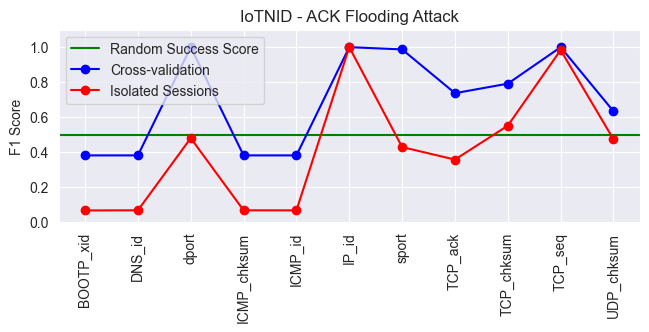

ARP
ARP


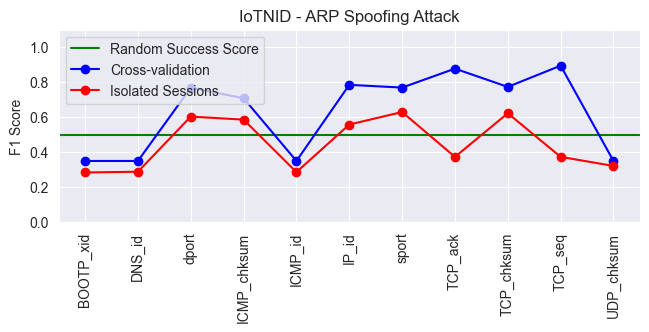

BF
BF


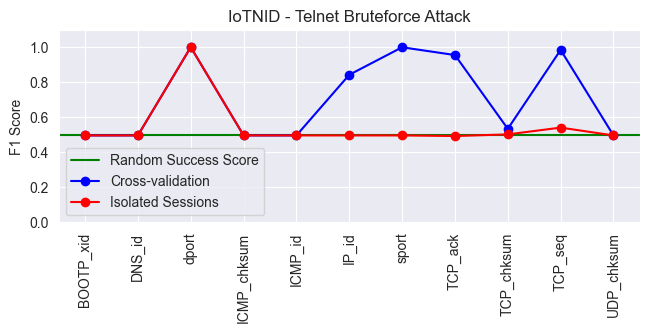

HTTP
HTTP


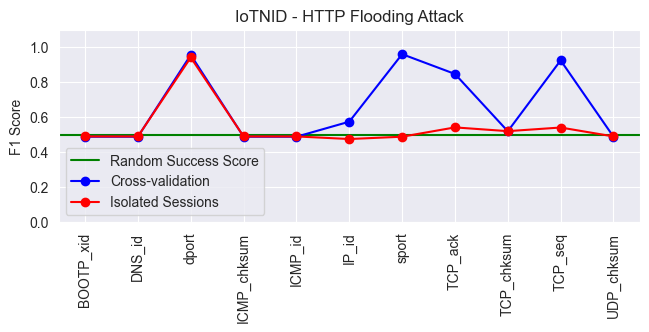

MHDis
MHDis


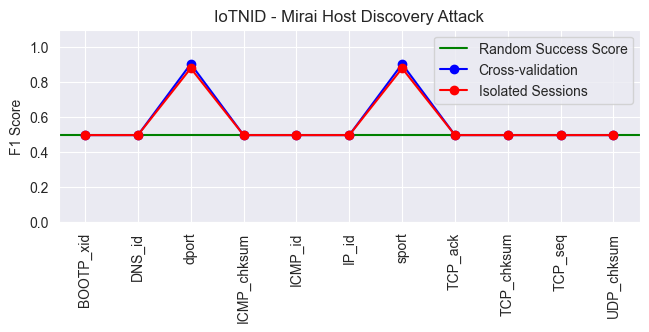

OS
OS


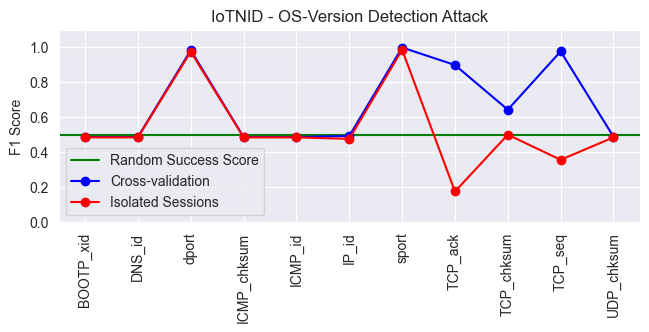

SCHD
SCHD


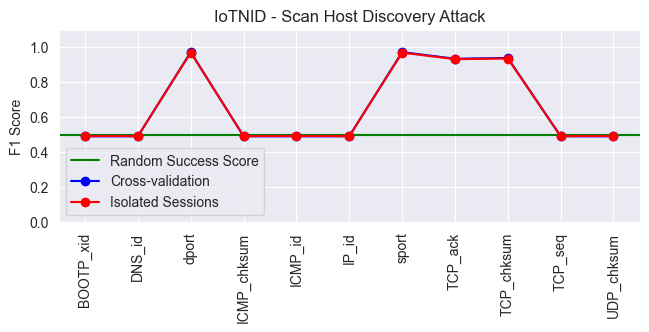

SP
SP


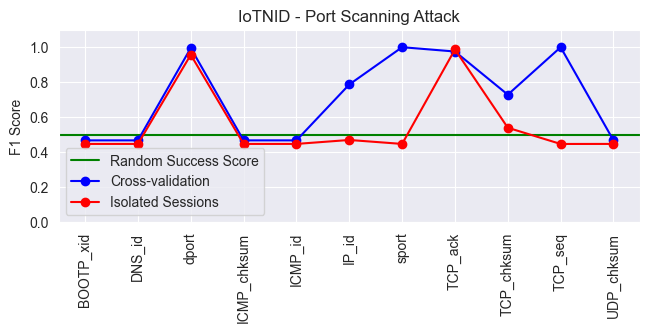

SYN
SYN


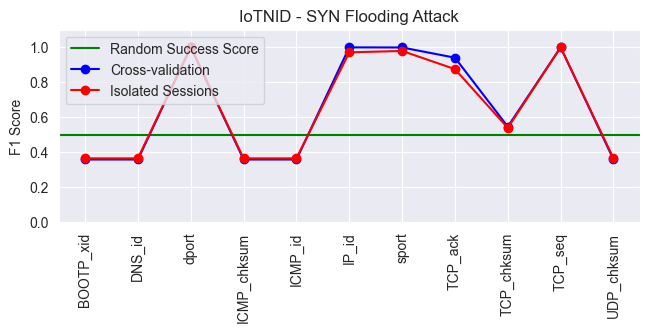

UDP
UDP


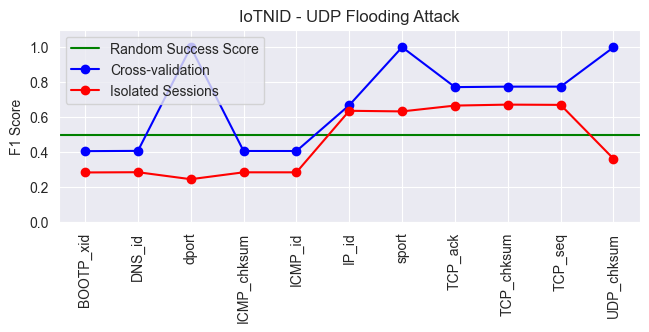

In [43]:
sns.set_style("darkgrid")
for i in results["attack"].unique():
    df=results[results["attack"]==i]
    plt.figure(figsize=(7.5,2.5))
    plt.axhline(0.5   , color='g', label= "Random Success Score")## hepsi
    for ii in ["CV","SS"]:
        data=df[df["type"]==ii]
        print(i)
        plt.plot(data["Feature"] ,data["F1"], linestyle='-', marker='o', color=colors[ii],label= labels[ii])
        plt.title(f"IoTNID - {attacks[i]} Attack")
        plt.legend(numpoints=1)
        plt.ylabel("F1 Score")
        plt.xticks(rotation=90) 
        plt.ylim(0,1.1)
    plt.savefig(f"IoTNID - {i} Attack.pdf",bbox_inches='tight',format="pdf")#, dpi=400)
    plt.show()

In [56]:
data

,type,Feature,attack,Acc,b_Acc,Prec,Rec,F1,kap,ROC
247,SS,BOOTP_xid,UDP,0.396600,0.500000,0.198300,0.500000,0.283975,0.000000,0.500000
248,SS,DNS_id,UDP,0.397290,0.500572,0.698437,0.500572,0.285258,0.000907,0.500572
249,SS,dport,UDP,0.324696,0.269055,0.225077,0.269055,0.245109,-0.486680,0.269055
250,SS,dport_class,UDP,0.589540,0.659877,0.745707,0.659877,0.571778,0.271588,0.659877
251,SS,ICMP_chksum,UDP,0.397052,0.500375,0.698390,0.500375,0.284816,0.000594,0.500375
252,SS,ICMP_id,UDP,0.397000,0.500331,0.698379,0.500331,0.284719,0.000526,0.500331
253,SS,IP_id,UDP,0.642586,0.699618,0.744965,0.699618,0.636335,0.348373,0.699618
254,SS,sport,UDP,0.719146,0.646400,0.836766,0.646400,0.632555,0.332878,0.646400
255,SS,sport_class,UDP,0.823450,0.853704,0.845983,0.853704,0.823288,0.657269,0.853704
256,SS,TCP_ack,UDP,0.671518,0.727807,0.773487,0.727807,0.666581,0.398987,0.727807


In [ ]:

graph_name="1.pdf"
my_xticks=data["Dataset"]

plt.figure(figsize=(10,10))
plt.plot(my_xticks,data["A"], linestyle='-', marker='o', color='b',label= "A")
plt.plot(my_xticks,data["B"], linestyle='-', marker='o', color='r',label= "B")
plt.plot(my_xticks,data["C"], linestyle='-', marker='o', color='k',label= "C")
plt.plot(my_xticks,data["D"], linestyle='-', marker='o', color='g',label= "D")
plt.title("ML Scores ")
plt.legend(numpoints=1)
plt.ylabel("F1 Score")
plt.xticks(rotation=90) 
plt.ylim([-10, 110]) 
plt.savefig(graph_name,bbox_inches='tight',format="pdf")#, dpi=400)

In [54]:
results

,type,Feature,attack,Acc,b_Acc,Prec,Rec,F1,kap,ROC
0,CV,BOOTP_xid,ACK,0.616725,0.500000,0.308363,0.500000,0.381461,0.000000,0.500000
1,CV,DNS_id,ACK,0.616725,0.500000,0.308362,0.500000,0.381459,0.000000,0.500000
2,CV,dport,ACK,0.999850,0.999841,0.999842,0.999841,0.999841,0.999683,0.999841
3,CV,dport_class,ACK,0.894275,0.896564,0.885512,0.896564,0.889883,0.780031,0.896564
4,CV,ICMP_chksum,ACK,0.616725,0.500000,0.308362,0.500000,0.381459,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...
255,SS,sport_class,UDP,0.823450,0.853704,0.845983,0.853704,0.823288,0.657269,0.853704
256,SS,TCP_ack,UDP,0.671518,0.727807,0.773487,0.727807,0.666581,0.398987,0.727807
257,SS,TCP_chksum,UDP,0.676182,0.731672,0.775257,0.731672,0.671686,0.406473,0.731672
258,SS,TCP_seq,UDP,0.674902,0.730612,0.774769,0.730612,0.670288,0.404416,0.730612
